In [37]:
#Importo los modulos necesarios.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import learning_curve

from collections import defaultdict


In [6]:
df = pd.read_csv(r"D:\desarrollo\club-de-datos\club-de-datos-python\data\data_modelo.csv")


In [14]:

# 1. Definir columnas
col_categoricas = ['provincia', 'ciudad', 'tipo_propiedad']
col_numericas = ['ambientes', 'dormitorios', 'baños', 'superficie_total', 'superficie_cubierta']

# 2. Separar X e y
X = df.drop(columns = ['precio'])
Y = df["precio"].to_numpy()

print(X.shape,Y.shape)

(122818, 9) (122818,)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape)

y_train_series = pd.Series(y_train, index=X_train.index)

# Samplear
X_sample = X_train.sample(frac=0.1, random_state=42)
y_sample = y_train_series.loc[X_sample.index]

print(X_sample.shape, y_sample.shape)

(98254, 9) (98254,)
(9825, 9) (9825,)


In [16]:
# 4. Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), col_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), col_categoricas)
    ]
)

In [29]:
# 5. Modelo completo
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=50, random_state=42))
])



In [30]:
# 6. Entrenar


model.fit(X_sample, y_sample)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


MAE:  43551.74
RMSE: 102727.40
R²:   0.85


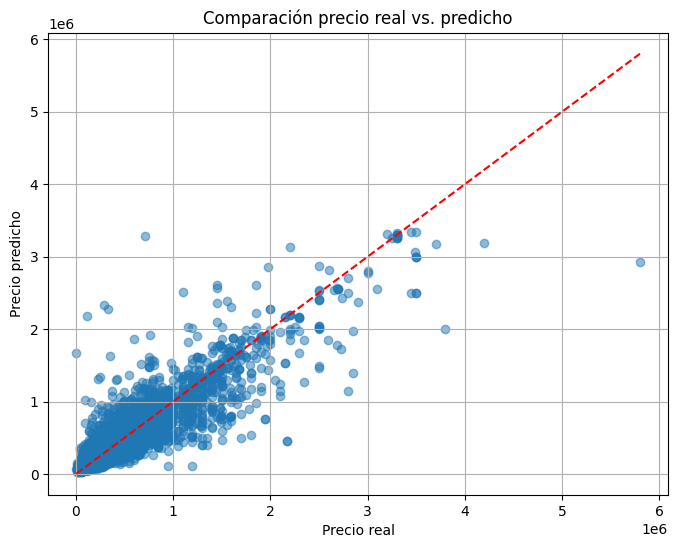

In [31]:
# 1. Predecimos en el set de prueba
y_pred = model.predict(X_test)

# 2. Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

#✅ MAE (Error Absoluto Medio)
#Valor promedio en que el modelo se equivoca, sin importar si es arriba o abajo.
print(f"MAE:  {mae:.2f}")

#✅ RMSE (Raíz del Error Cuadrático Medio)
#Penaliza más los errores grandes. Aumenta mucho si el modelo se equivoca fuerte en algunos casos.
print(f"RMSE: {rmse:.2f}")

#✅ R² (Coeficiente de Determinación)
#El porcentaje de variacion que logro explicar el modelo
print(f"R²:   {r2:.2f}")

# 3. Gráfico: precios reales vs. predichos
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Línea ideal
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Comparación precio real vs. predicho")
plt.grid(True)
plt.show()

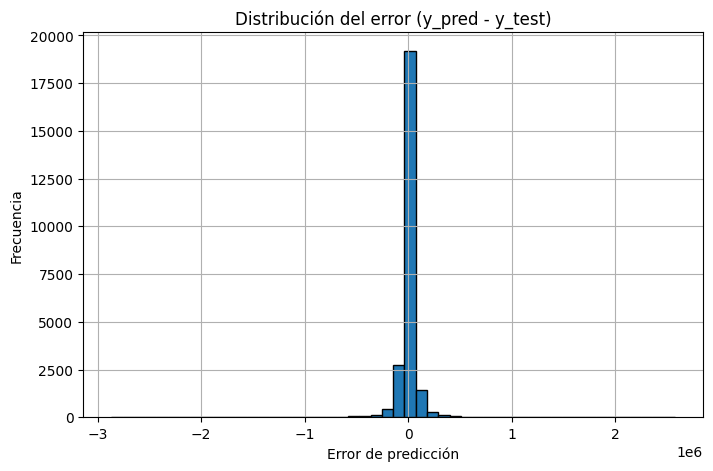

In [32]:
errors = y_pred - y_test

plt.figure(figsize=(8,5))
plt.hist(errors, bins=50, edgecolor='k')
plt.title("Distribución del error (y_pred - y_test)")
plt.xlabel("Error de predicción")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

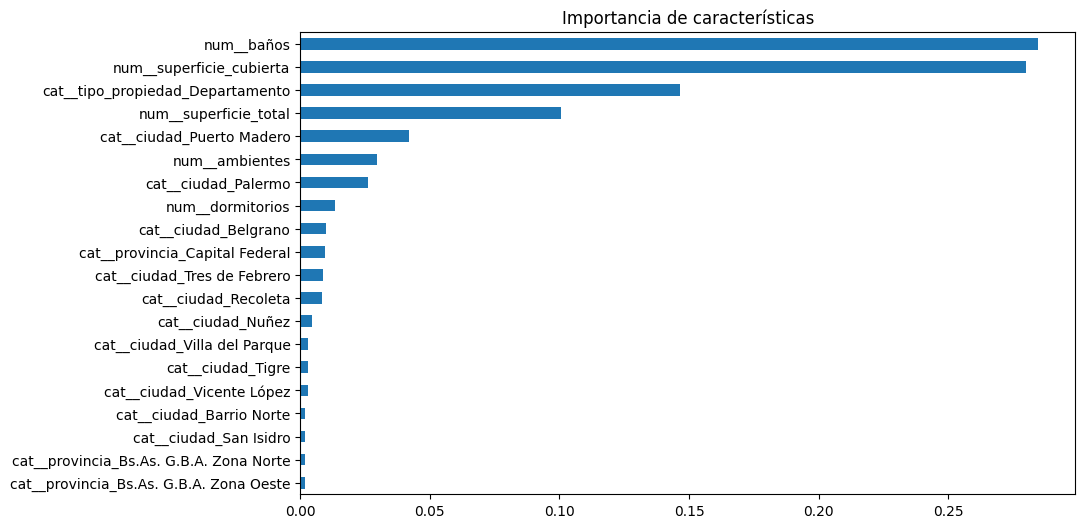

In [33]:
importances = model.named_steps['regressor'].feature_importances_
feature_names = model.named_steps['preprocessing'].get_feature_names_out()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

feat_imp.head(20).plot(kind='barh', figsize=(10,6), title="Importancia de características")
plt.gca().invert_yaxis()
plt.show()

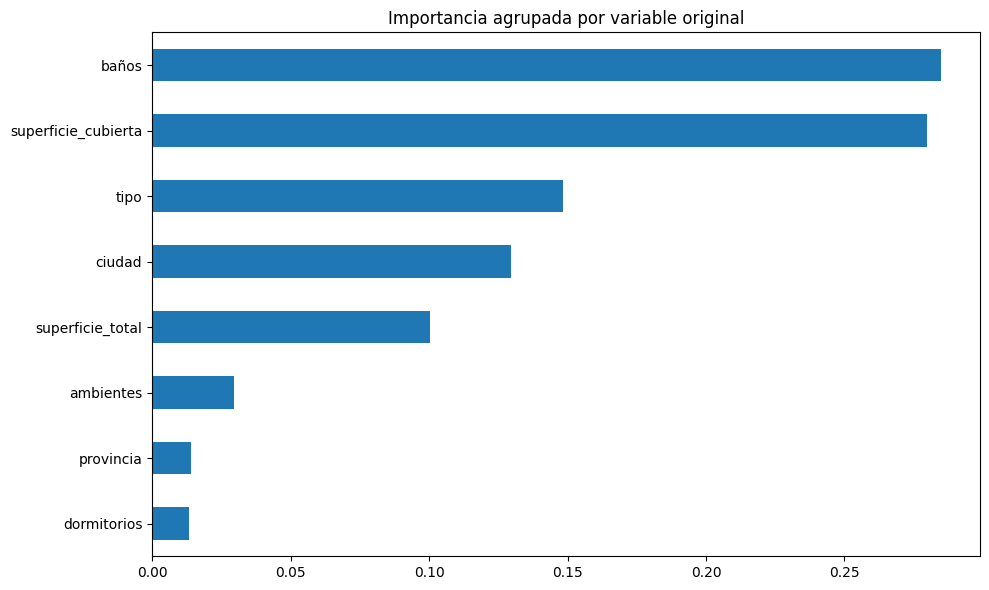

In [36]:
# Obtener nombres y pesos
feature_names = model.named_steps['preprocessing'].get_feature_names_out()
importances = model.named_steps['regressor'].feature_importances_

# Mapeo: 'ciudad_BsAs' -> 'ciudad'
grouped_importance = defaultdict(float)

for fname, importance in zip(feature_names, importances):
    if fname.startswith("num__"):
        key = fname.replace("num__", "")
    elif fname.startswith("cat__"):
        key = fname.split("__")[1].split("_")[0]  # e.g., 'ciudad' de 'cat__ciudad_Buenos Aires'
    else:
        key = fname  # fallback

    grouped_importance[key] += importance

# Convertir a Series y graficar
grouped_series = pd.Series(grouped_importance).sort_values(ascending=False)

grouped_series.plot(kind='barh', figsize=(10,6), title="Importancia agrupada por variable original")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

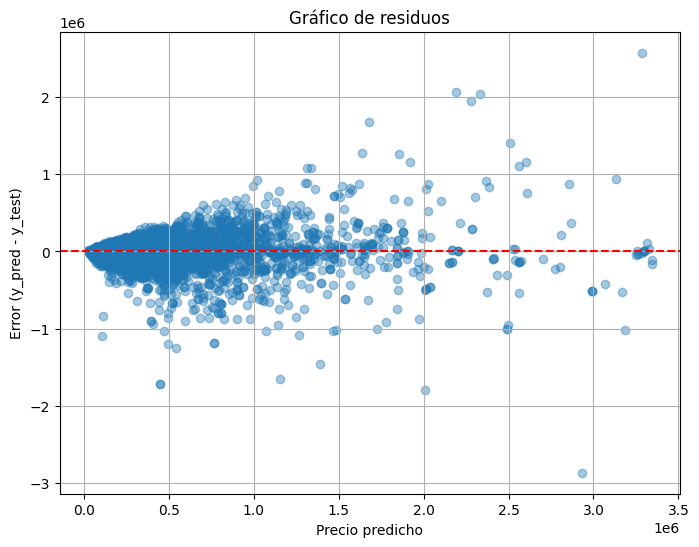

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(y_pred, errors, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Precio predicho")
plt.ylabel("Error (y_pred - y_test)")
plt.title("Gráfico de residuos")
plt.grid(True)
plt.show()

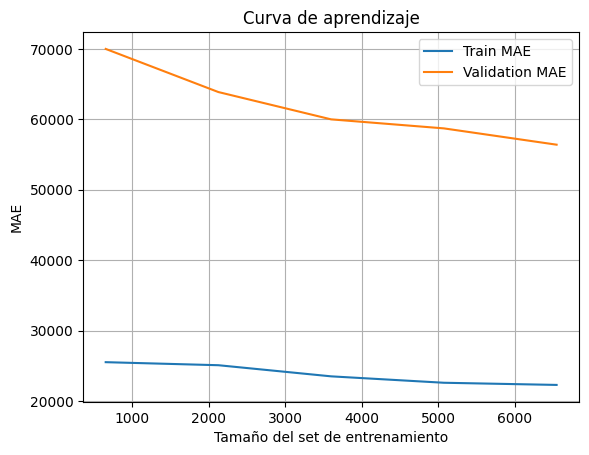

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    model, X_sample, y_sample, cv=3, scoring='neg_mean_absolute_error', 
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_mae = -train_scores.mean(axis=1)
val_mae = -val_scores.mean(axis=1)

plt.plot(train_sizes, train_mae, label='Entrenamiento MAE')
plt.plot(train_sizes, val_mae, label='validacion MAE')
plt.xlabel("Tamaño del set de entrenamiento")
plt.ylabel("MAE")
plt.title("Curva de aprendizaje")
plt.legend()
plt.grid(True)
plt.show()